# Imports

In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration

In [24]:
np.random.seed(42)
tf.random.set_seed(42)

# Custom Layers & Loss

In [25]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))
    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [26]:
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32) 
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        ce = -y_true * K.log(y_pred)
        loss = self.alpha * K.pow(1.0 - y_pred, self.gamma) * ce
        return K.mean(loss, axis=-1)


In [27]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(name='att_u',
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b)) 
        ait = K.dot(uit, self.u)                            
        ait = K.squeeze(ait, -1)                            
        a = K.softmax(ait)                                  
        a = K.expand_dims(a, -1)                            
        return K.sum(x * a, axis=1)                         


In [28]:
def jitter(x, sigma=0.03): return x + np.random.normal(0., sigma, x.shape)

In [ ]:
def scaling(x, sigma=0.1):
    factor = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[1],))
    return x * factor

In [ ]:
def permutation(x, max_segments=5):
    orig_steps = np.arange(x.shape[0])
    num_segs = np.random.randint(1, max_segments)
    segs = np.array_split(orig_steps, num_segs)
    np.random.shuffle(segs)
    permuted = np.concatenate(segs)
    return x[permuted]

# Load & Preprocess Data

In [29]:
can_data = pd.read_csv("~/road/signal_extractions/attacks/correlated_signal_attack_1_masquerade.csv")
can_data.fillna(0, inplace=True)

signal_columns = [col for col in can_data.columns if "Signal" in col]
can_data['Time'] = pd.to_datetime(can_data['Time'], unit='s')
can_data = can_data.sort_values('Time').set_index('Time')
can_data[signal_columns] = can_data[signal_columns].apply(pd.to_numeric, errors='coerce')
can_data = can_data.resample('100us').mean().interpolate(method='cubic').reset_index()


#  Sliding Window Creation

In [30]:
def create_time_series(data, window_size, step_size):
    sequences, labels = [], []
    for i in range(0, len(data) - window_size, step_size):
        window = data.iloc[i:i + window_size]
        sequences.append(window[signal_columns].values)
        labels.append(1 if (window['Label'].sum() > 0) else 0)
    return np.array(sequences), np.array(labels)

In [31]:
sampling_rate = 10000
window_size = 10
step_size = 1
X, y = create_time_series(can_data, window_size, step_size)

# SPLIT + SCALING

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

In [33]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)


Oversampling minority

In [34]:
train_df = pd.DataFrame(X_train.reshape(X_train.shape[0], -1))
train_df['label'] = y_train
majority = train_df[train_df['label'] == 0]
minority = train_df[train_df['label'] == 1]
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
balanced = pd.concat([majority, minority_upsampled])
X_train = balanced.drop('label', axis=1).values.reshape(-1, X_train.shape[1], X_train.shape[2])
y_train = balanced['label'].values

# Models

In [35]:
def build_model(attention=False):
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(64, return_sequences=True)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.LSTM(32, return_sequences=attention)(x)
    if attention:
        x = AttentionLayer()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, outputs)

# Training

In [36]:
EPOCHS = 20
BATCH_SIZE = 64
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_standard = build_model(attention=False)
model_standard.compile(optimizer=tf.keras.optimizers.Adam(0.001, clipnorm=1.0),
                       loss='binary_crossentropy',
                       metrics=['accuracy', Precision(), Recall(), F1Score()])
model_standard.fit(X_train, y_train, validation_data=(X_test, y_test),
                   epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stop], verbose=2)

Epoch 1/20
5162/5162 - 136s - 26ms/step - accuracy: 0.5111 - f1_score: 0.4712 - loss: 0.6918 - precision_10: 0.5131 - recall_10: 0.4355 - val_accuracy: 0.6239 - val_f1_score: 0.0000e+00 - val_loss: 0.6926 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 2/20
5162/5162 - 50s - 10ms/step - accuracy: 0.5262 - f1_score: 0.3903 - loss: 0.6884 - precision_10: 0.5472 - recall_10: 0.3033 - val_accuracy: 0.6250 - val_f1_score: 0.0064 - val_loss: 0.6677 - val_precision_10: 0.8889 - val_recall_10: 0.0032
Epoch 3/20
5162/5162 - 49s - 10ms/step - accuracy: 0.5726 - f1_score: 0.4644 - loss: 0.6694 - precision_10: 0.6218 - recall_10: 0.3706 - val_accuracy: 0.6245 - val_f1_score: 0.0035 - val_loss: 0.6629 - val_precision_10: 0.8800 - val_recall_10: 0.0018
Epoch 4/20
5162/5162 - 50s - 10ms/step - accuracy: 0.5994 - f1_score: 0.4814 - loss: 0.6538 - precision_10: 0.6823 - recall_10: 0.3719 - val_accuracy: 0.6254 - val_f1_score: 0.0104 - val_loss: 0.6587 - val_precision_10: 0.8125 - val_r

# Model with Focal Loss

In [37]:
model_focal = build_model(attention=False)
model_focal.compile(optimizer='adam', loss=FocalLoss(), metrics=['accuracy', Precision(), Recall(), F1Score()])
model_focal.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS,
                batch_size=BATCH_SIZE, callbacks=[early_stop], verbose=2)


Epoch 1/20
5162/5162 - 89s - 17ms/step - accuracy: 0.5000 - f1_score: 0.6667 - loss: 3.0286e-05 - precision_12: 0.5000 - recall_12: 1.0000 - val_accuracy: 0.3761 - val_f1_score: 0.5466 - val_loss: 2.0709e-13 - val_precision_12: 0.3761 - val_recall_12: 1.0000
Epoch 2/20
5162/5162 - 49s - 9ms/step - accuracy: 0.5000 - f1_score: 0.6667 - loss: 3.9688e-09 - precision_12: 0.5000 - recall_12: 1.0000 - val_accuracy: 0.3761 - val_f1_score: 0.5466 - val_loss: 2.8973e-16 - val_precision_12: 0.3761 - val_recall_12: 1.0000
Epoch 3/20
5162/5162 - 49s - 9ms/step - accuracy: 0.5000 - f1_score: 0.6667 - loss: 5.3217e-09 - precision_12: 0.5000 - recall_12: 1.0000 - val_accuracy: 0.3761 - val_f1_score: 0.5466 - val_loss: 2.9066e-17 - val_precision_12: 0.3761 - val_recall_12: 1.0000
Epoch 4/20
5162/5162 - 49s - 9ms/step - accuracy: 0.5000 - f1_score: 0.6667 - loss: 4.8247e-10 - precision_12: 0.5000 - recall_12: 1.0000 - val_accuracy: 0.3761 - val_f1_score: 0.5466 - val_loss: 2.9737e-18 - val_precision_12

# Attention Model

In [38]:
model_attention = build_model(attention=True)
model_attention.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), F1Score()])
model_attention.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stop], verbose=2)

Epoch 1/20


5162/5162 - 64s - 12ms/step - accuracy: 0.5011 - f1_score: 0.4878 - loss: 0.6932 - precision_14: 0.5012 - recall_14: 0.4751 - val_accuracy: 0.6307 - val_f1_score: 0.0396 - val_loss: 0.6921 - val_precision_14: 0.9016 - val_recall_14: 0.0202
Epoch 2/20
5162/5162 - 51s - 10ms/step - accuracy: 0.5580 - f1_score: 0.4837 - loss: 0.6757 - precision_14: 0.5814 - recall_14: 0.4142 - val_accuracy: 0.6821 - val_f1_score: 0.3248 - val_loss: 0.6354 - val_precision_14: 0.8075 - val_recall_14: 0.2033
Epoch 3/20
5162/5162 - 51s - 10ms/step - accuracy: 0.5936 - f1_score: 0.4565 - loss: 0.6557 - precision_14: 0.6890 - recall_14: 0.3413 - val_accuracy: 0.6903 - val_f1_score: 0.3794 - val_loss: 0.6302 - val_precision_14: 0.7704 - val_recall_14: 0.2517
Epoch 4/20
5162/5162 - 51s - 10ms/step - accuracy: 0.6040 - f1_score: 0.4785 - loss: 0.6482 - precision_14: 0.7005 - recall_14: 0.3634 - val_accuracy: 0.6891 - val_f1_score: 0.3577 - val_loss: 0.6272 - val_precision_14: 0.8023 - val_recall_14: 0.2301
Epoch 5

# Data augmentation

In [39]:
attack_idx = np.where(y_train == 1)[0]
X_augmented = np.array([jitter(sample) for sample in X_train[attack_idx]])
y_augmented = np.ones(len(X_augmented))
X_train_aug = np.concatenate([X_train, X_augmented])
y_train_aug = np.concatenate([y_train, y_augmented])

In [40]:
model_aug = build_model(attention=False)
model_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), F1Score()])
model_aug.fit(X_train_aug, y_train_aug, validation_data=(X_test, y_test), epochs=EPOCHS,
              batch_size=BATCH_SIZE, callbacks=[early_stop], verbose=2)

Epoch 1/20
7742/7742 - 117s - 15ms/step - accuracy: 0.7073 - f1_score: 0.7567 - loss: 0.4633 - precision_16: 0.8488 - recall_16: 0.6826 - val_accuracy: 0.6815 - val_f1_score: 0.4984 - val_loss: 0.6522 - val_precision_16: 0.6113 - val_recall_16: 0.4207
Epoch 2/20
7742/7742 - 70s - 9ms/step - accuracy: 0.7058 - f1_score: 0.7414 - loss: 0.4486 - precision_16: 0.8952 - recall_16: 0.6327 - val_accuracy: 0.6407 - val_f1_score: 0.0933 - val_loss: 0.6719 - val_precision_16: 0.9182 - val_recall_16: 0.0492
Epoch 3/20
7742/7742 - 70s - 9ms/step - accuracy: 0.7198 - f1_score: 0.7624 - loss: 0.4394 - precision_16: 0.8771 - recall_16: 0.6742 - val_accuracy: 0.6832 - val_f1_score: 0.5358 - val_loss: 0.6382 - val_precision_16: 0.5969 - val_recall_16: 0.4861
Epoch 4/20
7742/7742 - 70s - 9ms/step - accuracy: 0.7456 - f1_score: 0.7844 - loss: 0.4243 - precision_16: 0.9014 - recall_16: 0.6943 - val_accuracy: 0.7132 - val_f1_score: 0.5015 - val_loss: 0.6210 - val_precision_16: 0.7242 - val_recall_16: 0.383

# Ensemble

In [57]:
models_list = [model_standard, model_focal, model_attention, model_aug]
preds = [m.predict(X_test) for m in models_list]
ensemble_preds = np.mean(preds, axis=0)
y_pred = (ensemble_preds > 0.5).astype(int) 

2069/2069 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
2069/2069 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
2069/2069 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
2069/2069 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


In [58]:

print("\n--- ENSEMBLE PERFORMANCE ---")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")


--- ENSEMBLE PERFORMANCE ---
              precision    recall  f1-score   support

      Normal       0.97      0.00      0.00     41303
      Attack       0.38      1.00      0.55     24899

    accuracy                           0.38     66202
   macro avg       0.67      0.50      0.28     66202
weighted avg       0.75      0.38      0.21     66202

Accuracy: 0.3771
Precision: 0.3765
Recall: 0.9999
F1-score: 0.5470


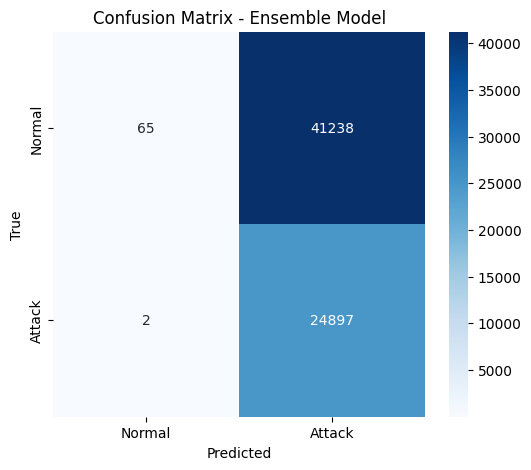

In [59]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Confusion Matrix - Ensemble Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Test de Seuil

In [60]:
best_threshold = 0.5
best_f1 = 0.0

thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (ensemble_preds > threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

Afficher le meilleur seuil

In [61]:
print(f"\n Meilleur seuil = {best_threshold:.2f} avec F1-score = {best_f1:.4f}")


 Meilleur seuil = 0.54 avec F1-score = 0.6069


Courbe F1 en fonction du seuil

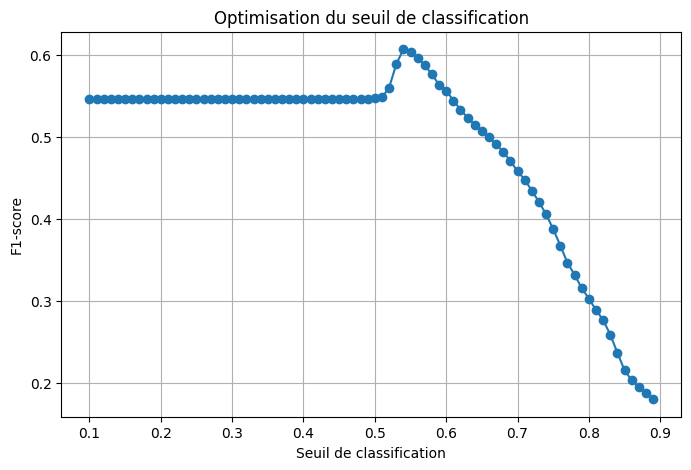

In [62]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, marker='o')
plt.xlabel('Seuil de classification')
plt.ylabel('F1-score')
plt.title('Optimisation du seuil de classification')
plt.grid(True)
plt.show()

Réévaluer les performances avec le seuil optimal

In [63]:
y_pred_opt = (ensemble_preds > best_threshold).astype(int)
print("\n--- ÉVALUATION AVEC SEUIL OPTIMISÉ ---")
print(classification_report(y_test, y_pred_opt, target_names=['Normal', 'Attack']))
print(f"Accuracy: {accuracy_score(y_test, y_pred_opt):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_opt):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_opt):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_opt):.4f}")


--- ÉVALUATION AVEC SEUIL OPTIMISÉ ---
              precision    recall  f1-score   support

      Normal       0.79      0.56      0.66     41303
      Attack       0.51      0.75      0.61     24899

    accuracy                           0.63     66202
   macro avg       0.65      0.66      0.63     66202
weighted avg       0.68      0.63      0.64     66202

Accuracy: 0.6337
Precision: 0.5088
Recall: 0.7520
F1-score: 0.6069


Confusion Matrix

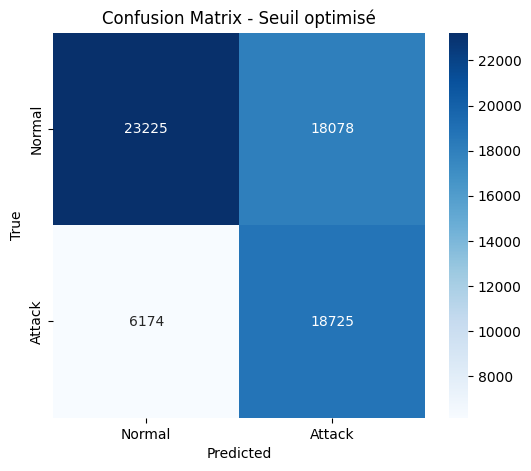

In [64]:
cm = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Confusion Matrix - Seuil optimisé")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

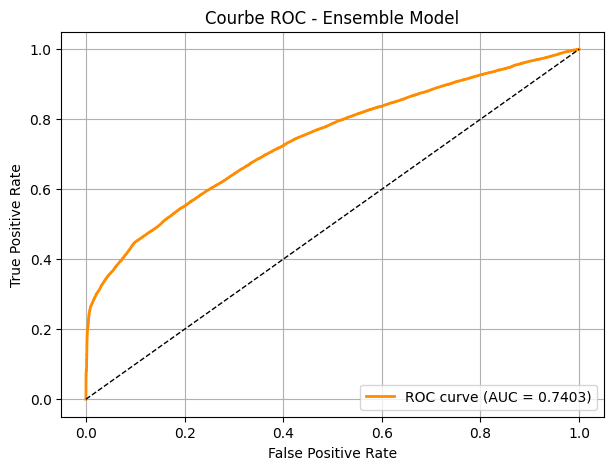

In [65]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# --- ROC Curve and AUC ---
fpr, tpr, _ = roc_curve(y_test, ensemble_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})', color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC - Ensemble Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()




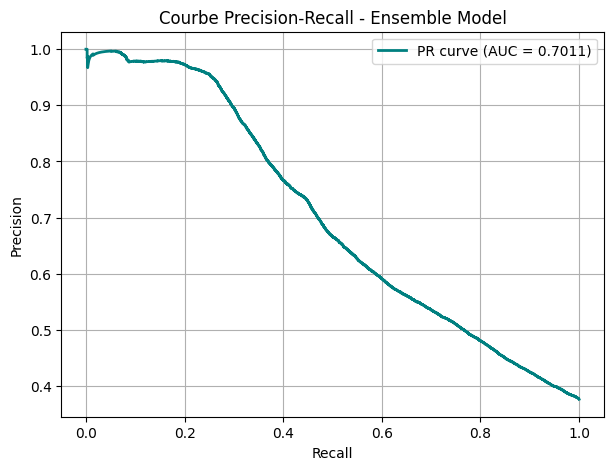

In [66]:
# --- Precision-Recall Curve and AUC ---
precision, recall, _ = precision_recall_curve(y_test, ensemble_preds)
pr_auc = auc(recall, precision)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})', color='teal', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe Precision-Recall - Ensemble Model')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()